In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import matplotlib.pyplot as plt
from opt import generate_exclusion_list
from theano import tensor as T
sns.set_context('paper', font_scale=1.5)

/anaconda2/envs/compgen/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
proc_data = pd.read_pickle('data/exp2_data.pkl')

# exclude! ...
excluded = generate_exclusion_list(
    proc_data, training_contexts=7, goal_chance=1/4.)
for e in excluded:
    proc_data = proc_data[proc_data.subj != e]
uids = list(set(proc_data.subj))
print len(uids)

100%|██████████| 148/148 [01:59<00:00,  1.76it/s]


114


# Analyses

In [3]:
proc_data['Accuracy'] = proc_data['Reward'] / 10.0
proc_data['Training'] = proc_data.loc[:, 'Context'] < 8

Below, we plot the training data as a check that subjects learned the task

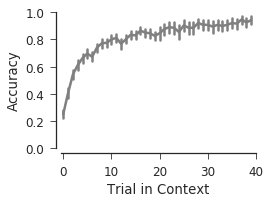

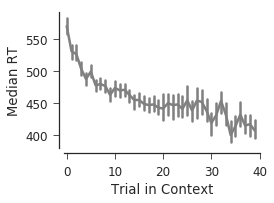

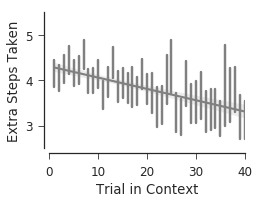

In [4]:
import scipy.stats
color = 'grey'
figsize = (3.5, 2.5)

with sns.axes_style('ticks'):
    plt.figure(figsize=figsize)
    ax = plt.gca()
    sns.pointplot(x='Times Seen Context', y='Accuracy', 
                  data=proc_data[proc_data['Training'] & proc_data['In Goal']],
                  ax=ax, markers=' ', color=color)
    lb, ub = ax.get_xlim()
    lb, ub = int(lb), int(ub)
    step = 10
    ax.set_xticks(range(lb, ub+2, step))
    ax.set_xticklabels(range(lb, ub+2, step))
    ax.set_ylim([0, 1])
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Trial in Context')
    sns.despine(offset=5)
    
    plt.figure(figsize=figsize)
    ax = plt.gca()
    sns.pointplot(x='Times Seen Context', y='rt', data=proc_data[proc_data['Training']], 
                  estimator=np.median, ax=ax,  markers=' ', color=color)
    ax.set_ylabel('Median RT')
    ax.set_xlabel('Trial in Context')
    ax.set_xticks(range(lb, ub+2, step))
    ax.set_xticklabels(range(lb, ub+2, step))
    sns.despine(offset=5)
    
    plt.figure(figsize=figsize)
    ax = plt.gca()
    sns.regplot(x='Times Seen Context', y='Normalized Steps Taken',
                x_estimator=np.mean,
                data=proc_data[proc_data['Training'] & proc_data['In Goal']],
                truncate=True,
                ax=ax, marker= ' ', color=color)
    ax.set_xticks(range(lb, ub+2, step))
    ax.set_xticklabels(range(lb, ub+2, step))
    ax.set_ylim([2.5, 5.5])
    ax.set_xlim([lb, ub+1])
    ax.set_xticks(range(lb, ub+2, step))
    ax.set_xticklabels(range(lb, ub+2, step))
    ax.set_ylabel('Extra Steps Taken')
    ax.set_xlabel('Trial in Context')
    sns.despine(offset=5)

In [5]:
# create meaningful regressors
# really on only want to look at training
X0 = proc_data[proc_data['Training'] & proc_data['In Goal']].copy()

X0['subj_id'] = [None] * len(X0)
for ii, uid in enumerate(uids):
    X0.loc[X0.subj == uid, 'sub_id'] = ii
n_subj = int(max(X0.sub_id) + 1)

y = np.array(X0['Accuracy'].values)
subj_idx = np.array(X0['sub_id'].values, dtype='int')
x_ti = X0['Times Seen Context'].values
x_cr = X0['Context Repeated'].values

def tinvlogit(x):
    return T.exp(x) / (1 + T.exp(x))

with pm.Model() as glm_train_acc:
    
    a = pm.Normal('alpha', mu=0., sd=100)
    
    # Intercept for each subjects, distributed around group mean mu_a
    b_ti = pm.Normal('beta_times', mu=0., sd=100.)
    b_cr = pm.Normal('beta_reps', mu=0., sd=100.)
    
    # random effects modeled as constant addded/subtracted per subject
    mu_sub = pm.Normal('mu_subj', mu=0., sd=100)
    sigma_sub = pm.HalfCauchy('sigma_sub', beta=100)
    a_sub = pm.Normal('a_subj', mu=mu_sub, sd=sigma_sub, shape=n_subj)
    
    # Regression model
    y_hat = tinvlogit(a + b_ti * x_ti + b_cr * x_cr + a_sub[subj_idx])
        
    #error term
    stdev = pm.HalfCauchy('eps', beta=100)
    
    # Data likelihood
    y_like = pm.Normal('like', mu=y_hat, sd=stdev, observed=y)
    
    trace_train_acc = pm.sample(2000)
    
pm.stats.summary(trace_train_acc, varnames=['beta_times', 'beta_reps'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/anaconda2/envs/compgen/lib/python2.7/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps_log__, a_subj, sigma_sub_log__, mu_subj, beta_reps, beta_times, alpha]
100%|██████████| 2500/2500 [06:54<00:00,  6.04it/s]
The acceptance probability does not match the target. It is 0.9304055172738868, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.5343979811035168, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller 

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta_times,0.114575,0.003514,0.000098,0.107228,0.121234,1298.0,0.999969
beta_reps,0.769869,0.046205,0.001121,0.677820,0.857705,1427.0,1.000523


In [6]:
y = np.array(1. / X0['rt'].values)
y = (y - y.mean()) / y.std()

with pm.Model() as glm_rt:
        
    # Intercept for each subjects, distributed around group mean mu_a
    b_ti = pm.Normal('beta_times', mu=0., sd=100.)
    b_cr = pm.Normal('beta_reps', mu=0., sd=100.)
    
    # random effects modeled as constant addded/subtracted per subject
    mu_sub = pm.Normal('mu_subj', mu=0., sd=100)
    sigma_sub = pm.HalfCauchy('sigma_sub', beta=100)
    a_sub = pm.Normal('a_subj', mu=mu_sub, sd=sigma_sub, shape=n_subj)
    
    # Regression model
    y_hat =  b_ti * x_ti + b_cr * x_cr + a_sub[subj_idx]
        
    #error term
    stdev = pm.HalfCauchy('eps', beta=100)
    
    # Data likelihood
    y_like = pm.Normal('like', mu=y_hat, sd=stdev, observed=y)
    
    # inference
    trace_rt = pm.sample(2000)
    
pm.stats.summary(trace_rt, varnames=['beta_times', 'beta_reps'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps_log__, a_subj, sigma_sub_log__, mu_subj, beta_reps, beta_times]
100%|██████████| 2500/2500 [03:40<00:00, 11.34it/s]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta_times,0.015757,0.000643,0.000010,0.014484,0.016966,3543.0,1.000062
beta_reps,0.082743,0.015427,0.000217,0.053200,0.114555,4000.0,0.999750


In [9]:
y = np.array(X0['Normalized Steps Taken'].values)

with pm.Model() as glm_steps:
    
    # Intercept for each subjects, distributed around group mean mu_a
    b_ti = pm.Normal('beta_times', mu=0., sd=5.)  # have to use a more restrictive prior for the Poisson regression
    b_cr = pm.Normal('beta_reps',  mu=0., sd=5.)
    
    # random effects modeled as constant addded/subtracted per subject
    mu_sub = pm.Normal('mu_subj', mu=0., sd=10.)
    sigma_sub = pm.HalfCauchy('sigma_sub', beta=10.)
    a_sub = pm.Normal('a_subj', mu=mu_sub, sd=sigma_sub, shape=n_subj)

    # define linear model and exp link function
    theta = b_ti * x_ti + b_cr * x_cr + a_sub[subj_idx]
            
    ## Define Poisson likelihood
    y_hat = pm.Poisson('y', mu=np.exp(theta), observed=y)
    
    # inference
    trace_steps = pm.sample(2000)
    
pm.stats.summary(trace_steps, varnames=['beta_times', 'beta_reps'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a_subj, sigma_sub_log__, mu_subj, beta_reps, beta_times]
100%|██████████| 2500/2500 [03:49<00:00, 10.89it/s]


JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/anaconda2/envs/compgen/lib/python2.7/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    169     pkg_name = mod_name.rpartition('.')[0]
    170     main_globals = sys.modules["__main__"].__dict__
    171     if alter_argv:
    172         sys.argv[0] = fname
    173     return _run_code(code, main_globals, None,
--> 174                      "__main__", fname, loader, pkg_name)
        fname = '/anaconda2/envs/compgen/lib/python2.7/site-packages/ipykernel_launcher.py'
        loader = <pkgutil.ImpLoader instance>
        pkg_name = ''
    175 
    176 def run_module(mod_name, init_globals=None,
    177                run_name=None, alter_sys=False):
    178     """Execute a module's code without importing it

...........................................................................
/anaconda2/envs/compgen/lib/python2.7/runpy.py in _run_code(code=<code object <module> at 0x1038a0bb0, file "/ana...2.7/site-packages/ipykernel_launcher.py", line 5>, run_globals={'__builtins__': <module '__builtin__' (built-in)>, '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/anaconda2/envs/compgen/lib/python2.7/site-packages/ipykernel_launcher.py', '__loader__': <pkgutil.ImpLoader instance>, '__name__': '__main__', '__package__': '', 'app': <module 'ipykernel.kernelapp' from '/anaconda2/e...python2.7/site-packages/ipykernel/kernelapp.pyc'>, 'sys': <module 'sys' (built-in)>}, init_globals=None, mod_name='__main__', mod_fname='/anaconda2/envs/compgen/lib/python2.7/site-packages/ipykernel_launcher.py', mod_loader=<pkgutil.ImpLoader instance>, pkg_name='')
     67         run_globals.update(init_globals)
     68     run_globals.update(__name__ = mod_name,
     69                        __file__ = mod_fname,
     70                        __loader__ = mod_loader,
     71                        __package__ = pkg_name)
---> 72     exec code in run_globals
        code = <code object <module> at 0x1038a0bb0, file "/ana...2.7/site-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__builtins__': <module '__builtin__' (built-in)>, '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/anaconda2/envs/compgen/lib/python2.7/site-packages/ipykernel_launcher.py', '__loader__': <pkgutil.ImpLoader instance>, '__name__': '__main__', '__package__': '', 'app': <module 'ipykernel.kernelapp' from '/anaconda2/e...python2.7/site-packages/ipykernel/kernelapp.pyc'>, 'sys': <module 'sys' (built-in)>}
     73     return run_globals
     74 
     75 def _run_module_code(code, init_globals=None,
     76                     mod_name=None, mod_fname=None,

...........................................................................
/anaconda2/envs/compgen/lib/python2.7/site-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
/anaconda2/envs/compgen/lib/python2.7/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/anaconda2/envs/compgen/lib/python2.7/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    481         if self.poller is not None:
    482             self.poller.start()
    483         self.kernel.start()
    484         self.io_loop = ioloop.IOLoop.current()
    485         try:
--> 486             self.io_loop.start()
        self.io_loop.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    487         except KeyboardInterrupt:
    488             pass
    489 
    490 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/anaconda2/envs/compgen/lib/python2.7/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    883                 self._events.update(event_pairs)
    884                 while self._events:
    885                     fd, events = self._events.popitem()
    886                     try:
    887                         fd_obj, handler_func = self._handlers[fd]
--> 888                         handler_func(fd_obj, events)
        handler_func = <function null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    889                     except (OSError, IOError) as e:
    890                         if errno_from_exception(e) == errno.EPIPE:
    891                             # Happens when the client closes the connection
    892                             pass

...........................................................................
/anaconda2/envs/compgen/lib/python2.7/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/anaconda2/envs/compgen/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    445             return
    446         zmq_events = self.socket.EVENTS
    447         try:
    448             # dispatch events:
    449             if zmq_events & zmq.POLLIN and self.receiving():
--> 450                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    451                 if not self.socket:
    452                     return
    453             if zmq_events & zmq.POLLOUT and self.sending():
    454                 self._handle_send()

...........................................................................
/anaconda2/envs/compgen/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    475             else:
    476                 raise
    477         else:
    478             if self._recv_callback:
    479                 callback = self._recv_callback
--> 480                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    481         
    482 
    483     def _handle_send(self):
    484         """Handle a send event."""

...........................................................................
/anaconda2/envs/compgen/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    427         close our socket."""
    428         try:
    429             # Use a NullContext to ensure that all StackContexts are run
    430             # inside our blanket exception handler rather than outside.
    431             with stack_context.NullContext():
--> 432                 callback(*args, **kwargs)
        callback = <function null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    433         except:
    434             gen_log.error("Uncaught exception in ZMQStream callback",
    435                           exc_info=True)
    436             # Re-raise the exception so that IOLoop.handle_callback_exception

...........................................................................
/anaconda2/envs/compgen/lib/python2.7/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/anaconda2/envs/compgen/lib/python2.7/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/anaconda2/envs/compgen/lib/python2.7/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {u'allow_stdin': True, u'code': u"y = np.array(X0['Normalized Steps Taken'].valu...ace_steps, varnames=['beta_times', 'beta_reps'])", u'silent': False, u'stop_on_error': True, u'store_history': True, u'user_expressions': {}}, 'header': {u'date': datetime.datetime(2018, 3, 9, 13, 53, 10, 85158, tzinfo=tzutc()), u'msg_id': u'1f450f0afc3848d780bdecc448344c58', u'msg_type': u'execute_request', u'session': u'15a03db153c44d4895da75ecec1c1aa4', u'username': u'username', u'version': u'5.2'}, 'metadata': {}, 'msg_id': u'1f450f0afc3848d780bdecc448344c58', 'msg_type': u'execute_request', 'parent_header': {}})
    228             self.log.warn("Unknown message type: %r", msg_type)
    229         else:
    230             self.log.debug("%s: %s", msg_type, msg)
    231             self.pre_handler_hook()
    232             try:
--> 233                 handler(stream, idents, msg)
        handler = <bound method IPythonKernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = ['15a03db153c44d4895da75ecec1c1aa4']
        msg = {'buffers': [], 'content': {u'allow_stdin': True, u'code': u"y = np.array(X0['Normalized Steps Taken'].valu...ace_steps, varnames=['beta_times', 'beta_reps'])", u'silent': False, u'stop_on_error': True, u'store_history': True, u'user_expressions': {}}, 'header': {u'date': datetime.datetime(2018, 3, 9, 13, 53, 10, 85158, tzinfo=tzutc()), u'msg_id': u'1f450f0afc3848d780bdecc448344c58', u'msg_type': u'execute_request', u'session': u'15a03db153c44d4895da75ecec1c1aa4', u'username': u'username', u'version': u'5.2'}, 'metadata': {}, 'msg_id': u'1f450f0afc3848d780bdecc448344c58', 'msg_type': u'execute_request', 'parent_header': {}}
    234             except Exception:
    235                 self.log.error("Exception in message handler:", exc_info=True)
    236             finally:
    237                 self.post_handler_hook()

...........................................................................
/anaconda2/envs/compgen/lib/python2.7/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=['15a03db153c44d4895da75ecec1c1aa4'], parent={'buffers': [], 'content': {u'allow_stdin': True, u'code': u"y = np.array(X0['Normalized Steps Taken'].valu...ace_steps, varnames=['beta_times', 'beta_reps'])", u'silent': False, u'stop_on_error': True, u'store_history': True, u'user_expressions': {}}, 'header': {u'date': datetime.datetime(2018, 3, 9, 13, 53, 10, 85158, tzinfo=tzutc()), u'msg_id': u'1f450f0afc3848d780bdecc448344c58', u'msg_type': u'execute_request', u'session': u'15a03db153c44d4895da75ecec1c1aa4', u'username': u'username', u'version': u'5.2'}, 'metadata': {}, 'msg_id': u'1f450f0afc3848d780bdecc448344c58', 'msg_type': u'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/anaconda2/envs/compgen/lib/python2.7/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code=u"y = np.array(X0['Normalized Steps Taken'].valu...ace_steps, varnames=['beta_times', 'beta_reps'])", silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    203 
    204         self._forward_input(allow_stdin)
    205 
    206         reply_content = {}
    207         try:
--> 208             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = u"y = np.array(X0['Normalized Steps Taken'].valu...ace_steps, varnames=['beta_times', 'beta_reps'])"
        store_history = True
        silent = False
    209         finally:
    210             self._restore_input()
    211 
    212         if res.error_before_exec is not None:

...........................................................................
/anaconda2/envs/compgen/lib/python2.7/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=(u"y = np.array(X0['Normalized Steps Taken'].valu...ace_steps, varnames=['beta_times', 'beta_reps'])",), **kwargs={'silent': False, 'store_history': True})
    532             )
    533         self.payload_manager.write_payload(payload)
    534 
    535     def run_cell(self, *args, **kwargs):
    536         self._last_traceback = None
--> 537         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = (u"y = np.array(X0['Normalized Steps Taken'].valu...ace_steps, varnames=['beta_times', 'beta_reps'])",)
        kwargs = {'silent': False, 'store_history': True}
    538 
    539     def _showtraceback(self, etype, evalue, stb):
    540         # try to preserve ordering of tracebacks and print statements
    541         sys.stdout.flush()

...........................................................................
/anaconda2/envs/compgen/lib/python2.7/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell=u"y = np.array(X0['Normalized Steps Taken'].valu...ace_steps, varnames=['beta_times', 'beta_reps'])", store_history=True, silent=False, shell_futures=True)
   2713                 self.displayhook.exec_result = result
   2714 
   2715                 # Execute the user code
   2716                 interactivity = "none" if silent else self.ast_node_interactivity
   2717                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2718                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler instance>
   2719                 
   2720                 self.last_execution_succeeded = not has_raised
   2721 
   2722                 # Reset this so later displayed values do not modify the

...........................................................................
/anaconda2/envs/compgen/lib/python2.7/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Assign object>, <_ast.With object>, <_ast.Expr object>], cell_name='<ipython-input-9-c41a0275edbc>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler instance>, result=<ExecutionResult object at 1242669d0, execution_..._before_exec=None error_in_exec=None result=None>)
   2817 
   2818         try:
   2819             for i, node in enumerate(to_run_exec):
   2820                 mod = ast.Module([node])
   2821                 code = compiler(mod, cell_name, "exec")
-> 2822                 if self.run_code(code, result):
        self.run_code = <bound method ZMQInteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x123625b30, file "<ipython-input-9-c41a0275edbc>", line 3>
        result = <ExecutionResult object at 1242669d0, execution_..._before_exec=None error_in_exec=None result=None>
   2823                     return True
   2824 
   2825             for i, node in enumerate(to_run_interactive):
   2826                 mod = ast.Interactive([node])

...........................................................................
/anaconda2/envs/compgen/lib/python2.7/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x123625b30, file "<ipython-input-9-c41a0275edbc>", line 3>, result=<ExecutionResult object at 1242669d0, execution_..._before_exec=None error_in_exec=None result=None>)
   2877         outflag = 1  # happens in more places, so it's easier as default
   2878         try:
   2879             try:
   2880                 self.hooks.pre_run_code_hook()
   2881                 #rprint('Running code', repr(code_obj)) # dbg
-> 2882                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x123625b30, file "<ipython-input-9-c41a0275edbc>", line 3>
        self.user_global_ns = {'In': ['', u"get_ipython().magic(u'matplotlib inline')\nimp...r as T\nsns.set_context('paper', font_scale=1.5)", u"proc_data = pd.read_pickle('data/exp2_data.pkl...ids = list(set(proc_data.subj))\nprint len(uids)", u"proc_data['Accuracy'] = proc_data['Reward'] / ...ta['Training'] = proc_data.loc[:, 'Context'] < 8", u"import scipy.stats\ncolor = 'grey'\nfigsize = ...l('Trial in Context')\n    sns.despine(offset=5)", u"# create meaningful regressors\n# really on on...train_acc, varnames=['beta_times', 'beta_reps'])", u"y = np.array(1. / X0['rt'].values)\ny = (y - y...(trace_rt, varnames=['beta_times', 'beta_reps'])", u"y = np.array(X0['Normalized Steps Taken'].valu...ace_steps, varnames=['beta_times', 'beta_reps'])", u"y = np.array(X0['Normalized Steps Taken'].valu...ace_steps, varnames=['beta_times', 'beta_reps'])", u"y = np.array(X0['Normalized Steps Taken'].valu...ace_steps, varnames=['beta_times', 'beta_reps'])"], 'Out': {5:                 mean        sd  mc_error   hpd_2...5  0.001121  0.677820  0.857705  1427.0  1.000523, 6:                 mean        sd  mc_error   hpd_2...7  0.000217  0.053200  0.114555  4000.0  0.999750}, 'T': <module 'theano.tensor' from '/anaconda2/envs/co...hon2.7/site-packages/theano/tensor/__init__.pyc'>, 'X0':        Action                                   ...True    None   113.0  

[18240 rows x 42 columns], '_':                 mean        sd  mc_error   hpd_2...7  0.000217  0.053200  0.114555  4000.0  0.999750, '_5':                 mean        sd  mc_error   hpd_2...5  0.001121  0.677820  0.857705  1427.0  1.000523, '_6':                 mean        sd  mc_error   hpd_2...7  0.000217  0.053200  0.114555  4000.0  0.999750, '__':                 mean        sd  mc_error   hpd_2...5  0.001121  0.677820  0.857705  1427.0  1.000523, '___': '', '__builtin__': <module '__builtin__' (built-in)>, ...}
        self.user_ns = {'In': ['', u"get_ipython().magic(u'matplotlib inline')\nimp...r as T\nsns.set_context('paper', font_scale=1.5)", u"proc_data = pd.read_pickle('data/exp2_data.pkl...ids = list(set(proc_data.subj))\nprint len(uids)", u"proc_data['Accuracy'] = proc_data['Reward'] / ...ta['Training'] = proc_data.loc[:, 'Context'] < 8", u"import scipy.stats\ncolor = 'grey'\nfigsize = ...l('Trial in Context')\n    sns.despine(offset=5)", u"# create meaningful regressors\n# really on on...train_acc, varnames=['beta_times', 'beta_reps'])", u"y = np.array(1. / X0['rt'].values)\ny = (y - y...(trace_rt, varnames=['beta_times', 'beta_reps'])", u"y = np.array(X0['Normalized Steps Taken'].valu...ace_steps, varnames=['beta_times', 'beta_reps'])", u"y = np.array(X0['Normalized Steps Taken'].valu...ace_steps, varnames=['beta_times', 'beta_reps'])", u"y = np.array(X0['Normalized Steps Taken'].valu...ace_steps, varnames=['beta_times', 'beta_reps'])"], 'Out': {5:                 mean        sd  mc_error   hpd_2...5  0.001121  0.677820  0.857705  1427.0  1.000523, 6:                 mean        sd  mc_error   hpd_2...7  0.000217  0.053200  0.114555  4000.0  0.999750}, 'T': <module 'theano.tensor' from '/anaconda2/envs/co...hon2.7/site-packages/theano/tensor/__init__.pyc'>, 'X0':        Action                                   ...True    None   113.0  

[18240 rows x 42 columns], '_':                 mean        sd  mc_error   hpd_2...7  0.000217  0.053200  0.114555  4000.0  0.999750, '_5':                 mean        sd  mc_error   hpd_2...5  0.001121  0.677820  0.857705  1427.0  1.000523, '_6':                 mean        sd  mc_error   hpd_2...7  0.000217  0.053200  0.114555  4000.0  0.999750, '__':                 mean        sd  mc_error   hpd_2...5  0.001121  0.677820  0.857705  1427.0  1.000523, '___': '', '__builtin__': <module '__builtin__' (built-in)>, ...}
   2883             finally:
   2884                 # Reset our crash handler in place
   2885                 sys.excepthook = old_excepthook
   2886         except SystemExit as e:

...........................................................................
/Users/nicholasfranklin/OneDrive/Projects/CompositionalGeneralization_paper/<ipython-input-9-c41a0275edbc> in <module>()
     16             
     17     ## Define Poisson likelihood
     18     y_hat = pm.Poisson('y', mu=np.exp(theta), observed=y)
     19     
     20     # inference
---> 21     trace_steps = pm.sample(2000)
     22     
     23 pm.stats.summary(trace_steps, varnames=['beta_times', 'beta_reps'])

...........................................................................
/anaconda2/envs/compgen/lib/python2.7/site-packages/pymc3/sampling.py in sample(draws=2500, step=<pymc3.step_methods.hmc.nuts.NUTS object>, init='auto', n_init=200000, start=[{'a_subj': array([ 0.75633369, -0.71684238,  0.24376127, -0...94260654,  0.68579268, -0.66029924, -0.17038973]), 'beta_reps': array(0.38708707), 'beta_times': array(-0.24187556), 'mu_subj': array(0.5034767), 'sigma_sub_log__': array(1.71024203)}, {'a_subj': array([-0.57379182,  0.33666492, -0.5172431 , -0...56219705, -0.92972618,  0.22663778, -0.89677496]), 'beta_reps': array(-0.5058099), 'beta_times': array(0.46487776), 'mu_subj': array(0.38165411), 'sigma_sub_log__': array(2.23000473)}], trace=None, chain_idx=0, chains=2, njobs=2, tune=500, nuts_kwargs=None, step_kwargs=None, progressbar=True, model=<pymc3.model.Model object>, random_seed=[952519241, 345382971], live_plot=False, discard_tuned_samples=True, live_plot_kwargs=None, compute_convergence_checks=True, **kwargs={})
    414     parallel = njobs > 1 and chains > 1 and not has_population_samplers
    415     if parallel:
    416         _log.info('Multiprocess sampling ({} chains in {} jobs)'.format(chains, njobs))
    417         _print_step_hierarchy(step)
    418         try:
--> 419             trace = _mp_sample(**sample_args)
        trace = None
        sample_args = {'chain': 0, 'chains': 2, 'draws': 2500, 'live_plot': False, 'live_plot_kwargs': None, 'model': <pymc3.model.Model object>, 'njobs': 2, 'progressbar': True, 'random_seed': [952519241, 345382971], 'start': [{'a_subj': array([ 0.75633369, -0.71684238,  0.24376127, -0...94260654,  0.68579268, -0.66029924, -0.17038973]), 'beta_reps': array(0.38708707), 'beta_times': array(-0.24187556), 'mu_subj': array(0.5034767), 'sigma_sub_log__': array(1.71024203)}, {'a_subj': array([-0.57379182,  0.33666492, -0.5172431 , -0...56219705, -0.92972618,  0.22663778, -0.89677496]), 'beta_reps': array(-0.5058099), 'beta_times': array(0.46487776), 'mu_subj': array(0.38165411), 'sigma_sub_log__': array(2.23000473)}], ...}
    420         except pickle.PickleError:
    421             _log.warn("Could not pickle model, sampling singlethreaded.")
    422             _log.debug('Pickling error:', exec_info=True)
    423             parallel = False

...........................................................................
/anaconda2/envs/compgen/lib/python2.7/site-packages/pymc3/sampling.py in _mp_sample(**kwargs={'draws': 2500, 'live_plot': False, 'live_plot_kwargs': None, 'model': <pymc3.model.Model object>, 'step': <pymc3.step_methods.hmc.nuts.NUTS object>, 'trace': None, 'tune': 500})
    944 
    945     chain_nums = list(range(chain, chain + chains))
    946     pbars = [kwargs.pop('progressbar')] + [False] * (chains - 1)
    947     jobs = (delayed(_sample)(*args, **kwargs)
    948             for args in zip(chain_nums, pbars, rseed, start))
--> 949     traces = Parallel(n_jobs=njobs)(jobs)
        traces = undefined
        njobs = 2
        jobs = <generator object <genexpr>>
    950     return MultiTrace(traces)
    951 
    952 
    953 def stop_tuning(step):

...........................................................................
/anaconda2/envs/compgen/lib/python2.7/site-packages/joblib/parallel.py in __call__(self=Parallel(n_jobs=2), iterable=<generator object <genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=2)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Fri Mar  9 08:53:23 2018
PID: 96232                Python 2.7.14: /anaconda2/envs/compgen/bin/python
...........................................................................
/anaconda2/envs/compgen/lib/python2.7/site-packages/joblib/parallel.py in __call__(self=<joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _sample>
        args = (1, False, 345382971, {'a_subj': array([-0.57379182,  0.33666492, -0.5172431 , -0...56219705, -0.92972618,  0.22663778, -0.89677496]), 'beta_reps': array(-0.5058099), 'beta_times': array(0.46487776), 'mu_subj': array(0.38165411), 'sigma_sub_log__': array(2.23000473)})
        kwargs = {'draws': 2500, 'live_plot': False, 'live_plot_kwargs': None, 'model': <pymc3.model.Model object>, 'step': <pymc3.step_methods.hmc.nuts.NUTS object>, 'trace': None, 'tune': 500}
        self.items = [(<function _sample>, (1, False, 345382971, {'a_subj': array([-0.57379182,  0.33666492, -0.5172431 , -0...56219705, -0.92972618,  0.22663778, -0.89677496]), 'beta_reps': array(-0.5058099), 'beta_times': array(0.46487776), 'mu_subj': array(0.38165411), 'sigma_sub_log__': array(2.23000473)}), {'draws': 2500, 'live_plot': False, 'live_plot_kwargs': None, 'model': <pymc3.model.Model object>, 'step': <pymc3.step_methods.hmc.nuts.NUTS object>, 'trace': None, 'tune': 500})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/anaconda2/envs/compgen/lib/python2.7/site-packages/pymc3/sampling.py in _sample(chain=1, progressbar=False, random_seed=345382971, start={'a_subj': array([-0.57379182,  0.33666492, -0.5172431 , -0...56219705, -0.92972618,  0.22663778, -0.89677496]), 'beta_reps': array(-0.5058099), 'beta_times': array(0.46487776), 'mu_subj': array(0.38165411), 'sigma_sub_log__': array(2.23000473)}, draws=2500, step=<pymc3.step_methods.hmc.nuts.NUTS object>, trace=None, tune=500, model=<pymc3.model.Model object>, live_plot=False, live_plot_kwargs=None, **kwargs={})
    521                             tune, model, random_seed)
    522     if progressbar:
    523         sampling = tqdm(sampling, total=draws)
    524     try:
    525         strace = None
--> 526         for it, strace in enumerate(sampling):
        it = 304
        strace = <pymc3.backends.ndarray.NDArray object>
        sampling = <generator object _iter_sample>
    527             if live_plot:
    528                 if live_plot_kwargs is None:
    529                     live_plot_kwargs = {}
    530                 if it >= skip_first:

...........................................................................
/anaconda2/envs/compgen/lib/python2.7/site-packages/pymc3/sampling.py in _iter_sample(draws=2500, step=<pymc3.step_methods.hmc.nuts.NUTS object>, start={'a_subj': array([-0.57379182,  0.33666492, -0.5172431 , -0...56219705, -0.92972618,  0.22663778, -0.89677496]), 'beta_reps': array(-0.5058099), 'beta_times': array(0.46487776), 'mu_subj': array(0.38165411), 'sigma_sub_log__': array(2.23000473)}, trace=None, chain=1, tune=500, model=<pymc3.model.Model object>, random_seed=345382971)
    619         step.tune = bool(tune)
    620         for i in range(draws):
    621             if i == tune:
    622                 step = stop_tuning(step)
    623             if step.generates_stats:
--> 624                 point, states = step.step(point)
        point = {'a_subj': array([-0.57379185,  0.33666484, -0.51724313, -0...56219697, -0.92972619,  0.22663774, -0.89677499]), 'beta_reps': array(-0.50581122), 'beta_times': array(0.46404053), 'mu_subj': array(0.38165409), 'sigma_sub_log__': array(2.23000474)}
        states = [{'depth': 1, 'diverging': False, 'energy': 78081525335.74301, 'energy_error': -357.35765075683594, 'max_energy_error': -357.35765075683594, 'mean_tree_accept': 1.0, 'step_size': 8.954459203372483e-06, 'step_size_bar': 6.555880122385227e-06, 'tree_size': 1, 'tune': True}]
        step.step = <bound method NUTS.step of <pymc3.step_methods.hmc.nuts.NUTS object>>
    625                 if strace.supports_sampler_stats:
    626                     strace.record(point, states)
    627                 else:
    628                     strace.record(point)

...........................................................................
/anaconda2/envs/compgen/lib/python2.7/site-packages/pymc3/step_methods/arraystep.py in step(self=<pymc3.step_methods.hmc.nuts.NUTS object>, point={'a_subj': array([-0.57379185,  0.33666484, -0.51724313, -0...56219697, -0.92972619,  0.22663774, -0.89677499]), 'beta_reps': array(-0.50581122), 'beta_times': array(0.46404053), 'mu_subj': array(0.38165409), 'sigma_sub_log__': array(2.23000474)})
    217     def step(self, point):
    218         self._logp_dlogp_func.set_extra_values(point)
    219         array = self._logp_dlogp_func.dict_to_array(point)
    220 
    221         if self.generates_stats:
--> 222             apoint, stats = self.astep(array)
        apoint = undefined
        stats = undefined
        self.astep = <bound method NUTS.astep of <pymc3.step_methods.hmc.nuts.NUTS object>>
        array = array([-0.57379185,  0.33666484, -0.51724313, -0...4,
        0.38165409, -0.50581122,  0.46404053])
    223             point = self._logp_dlogp_func.array_to_full_dict(apoint)
    224             return point, stats
    225         else:
    226             apoint = self.astep(array)

...........................................................................
/anaconda2/envs/compgen/lib/python2.7/site-packages/pymc3/step_methods/hmc/base_hmc.py in astep(self=<pymc3.step_methods.hmc.nuts.NUTS object>, q0=array([-0.57379185,  0.33666484, -0.51724313, -0...4,
        0.38165409, -0.50581122,  0.46404053]))
    110         """Perform a single HMC iteration."""
    111         p0 = self.potential.random()
    112         start = self.integrator.compute_state(q0, p0)
    113 
    114         if not np.isfinite(start.energy):
--> 115             self.potential.raise_ok()
        self.potential.raise_ok = <bound method QuadPotentialDiagAdapt.raise_ok of...hmc.quadpotential.QuadPotentialDiagAdapt object>>
    116             raise ValueError('Bad initial energy: %s. The model '
    117                              'might be misspecified.' % start.energy)
    118 
    119         adapt_step = self.tune and self.adapt_step_size

...........................................................................
/anaconda2/envs/compgen/lib/python2.7/site-packages/pymc3/step_methods/hmc/quadpotential.py in raise_ok(self=<pymc3.step_methods.hmc.quadpotential.QuadPotentialDiagAdapt object>)
    185 
    186         self._n_samples += 1
    187 
    188     def raise_ok(self):
    189         if np.any(self._stds == 0):
--> 190             raise ValueError('Mass matrix contains zeros on the diagonal. '
    191                              'Some derivatives might always be zero.')
    192         if np.any(self._stds < 0):
    193             raise ValueError('Mass matrix contains negative values on the '
    194                              'diagonal.')

ValueError: Mass matrix contains zeros on the diagonal. Some derivatives might always be zero.
___________________________________________________________________________

Here, we plot the differences scores for the test conditions across time. Thes are the a priori comparisons identified by the generative models

In [ ]:
# plot the difference scores across time
df0 = df = proc_data[~proc_data['Training'] & proc_data['In Goal'] & 
                     (proc_data['Times Seen Context'] < 6)].copy()

score = list()

for uid in uids:
    subj_df = df0.loc[df0.subj == uid, :]

    if subj_df['Trial Number'].max() == df0['Trial Number'].max():

        grouped = subj_df.groupby(['Context', 'Times Seen Context']).mean()

        diff_1 = grouped.loc[8, 'Accuracy'] - grouped.loc[9, 'Accuracy']
        diff_2 = (grouped.loc[8, 'Accuracy'] + grouped.loc[9, 'Accuracy']) * 0.5 -\
                   (grouped.loc[10, 'Accuracy'] + grouped.loc[11, 'Accuracy']) * 0.5
        diff_3 = grouped.loc[10, 'Accuracy'] -  grouped.loc[11, 'Accuracy']

        n = len(diff_1)

        score.append(pd.DataFrame({
                    'Trials in Context': range(1, n+1),
                    'Comparison': ['T1 vs T2'] * n,
                    'Difference Score': diff_1,
                    'uniqueid': [uid] * n,
            }))
        
        score.append(pd.DataFrame({
                    'Trials in Context': range(1, n+1),
                    'Comparison': ['T1/2 vs T3/4'] * n,
                    'Difference Score': diff_2,
                    'uniqueid': [uid] * n,
            }))
        
        score.append(pd.DataFrame({
                    'Trials in Context': range(1, n+1),
                    'Comparison': ['T3 vs T4'] * n,
                    'Difference Score': diff_3,
                    'uniqueid': [uid] * n,
            }))

score = pd.concat(score)      
with sns.axes_style('ticks'):
    fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)
    
    sns.pointplot(x='Trials in Context', y='Difference Score',  err_style='ci_bars',
                  ci=95, data=score[score.Comparison=='T1 vs T2'],  
                  ax=axes[0], color=[0.45, 0.45, 0.45])
    sns.pointplot(x='Trials in Context', y='Difference Score',  err_style='ci_bars',
                  ci=95, data=score[score.Comparison=='T1/2 vs T3/4'], 
                  ax=axes[1], color=[0.45, 0.45, 0.45])
    sns.pointplot(x='Trials in Context', y='Difference Score',  err_style='ci_bars',
                  ci=95, data=score[score.Comparison=='T3 vs T4'],  
                  ax=axes[2], color=[0.45, 0.45, 0.45])
    

    axes[0].set_xticklabels(range(1, 7))
    axes[0].set_ylabel('Difference Score')
    axes[1].set_ylabel('')
    axes[2].set_ylabel('')
    
    axes[0].set_title('T1 vs T2', fontdict={'size': 12})
    axes[1].set_title('T1/2 vs T3/4', fontdict={'size': 12})
    axes[2].set_title('T3 vs T4', fontdict={'size': 12})
    
    for ax in axes:
        ax.plot([0, 6], [0, 0], 'k:')
    
    plt.subplots_adjust(wspace=0.3)
    sns.despine(offset=5, trim=True)
    plt.tight_layout()


In [ ]:
# run the bayesian GLM

X0 = proc_data[~proc_data['Training'] & proc_data['In Goal']].copy()

X0['subj_id'] = [None] * len(X0)
for ii, uid in enumerate(uids):
    X0.loc[X0.subj == uid, 'sub_id'] = ii

n_subj = int(max(X0.sub_id) + 1)


y = np.array(X0['Accuracy'].values)
subj_idx = np.array(X0['sub_id'].values, dtype='int')
x_1 = np.array(X0.Context.values == 8, dtype=int) - \
     (X0.Context.values == 9 )
    
x_2 = np.array((X0.Context.values == 8) | (X0.Context.values == 9), dtype=int) - \
     ((X0.Context.values == 10) | (X0.Context.values == 11))
    
x_3 = np.array(X0.Context.values == 10, dtype=int) - \
     (X0.Context.values == 11)
    
x_ti = X0['Times Seen Context'].values
x_cr = X0['Context Repeated'].values

def tinvlogit(x):
    return T.exp(x) / (1 + T.exp(x))

with pm.Model() as glm:
        
    # Intercept for each subjects, distributed around group mean mu_a
    b_1 = pm.Normal('beta_ctxT1vs2',   mu=0., sd=100)
    b_2 = pm.Normal('beta_ctxT12vs34', mu=0., sd=100)
    b_3 = pm.Normal('beta_ctxT3vs4',   mu=0., sd=100)
    b_ti = pm.Normal('beta_times',     mu=0., sd=100)
    b_cr = pm.Normal('beta_reps',      mu=0., sd=100)
    
    # random effects modeled as constant addded/subtracted per subject
    mu_sub = pm.Normal('mu_subj', mu=0., sd=100)
    sigma_sub = pm.HalfCauchy('sigma_sub', beta=100)
    a_sub = pm.Normal('a_subj', mu=mu_sub, sd=sigma_sub, shape=n_subj)
    
    # Regression model
    y_hat = tinvlogit(b_1 * x_1 + b_2 * x_2 + b_3 * x_3 + \
                      b_ti * x_ti + b_cr * x_cr + a_sub[subj_idx])
        
    #error term
    stdev = pm.HalfCauchy('eps', beta=100)
    
    # Data likelihood
    y_like = pm.Normal('like', mu=y_hat, sd=stdev, observed=y)
    
    trace = pm.sample(2000)

In [ ]:
summary = pm.stats.summary(trace, varnames=[
    'beta_ctxT1vs2', 'beta_ctxT12vs34', 'beta_ctxT3vs4', 'beta_times', 'beta_reps'
])
summary

In [ ]:
# one sided tests
print 'P(1 > 2)     = %g' % np.mean(trace['beta_ctxT1vs2'] > 0)
print 'P(1+2 > 3+4) = %g' % np.mean(trace['beta_ctxT12vs34'] > 0)
print 'P(3 > 4)     = %g' % np.mean(trace['beta_ctxT3vs4'] > 0)

In [ ]:
# Compare model to a reduced model with out the contrasts
with pm.Model() as glm_reduced:
        
    # Intercept for each subjects, distributed around group mean mu_a
    b_ti = pm.Normal('beta_times',    mu=0., sd=100)
    b_cr = pm.Normal('beta_reps',     mu=0., sd=100)
    
    # random effects modeled as constant addded/subtracted per subject
    mu_sub = pm.Normal('mu_subj', mu=0., sd=100)
    sigma_sub = pm.HalfCauchy('sigma_sub', beta=100)
    a_sub = pm.Normal('a_subj', mu=mu_sub, sd=sigma_sub, shape=n_subj)
    
    # Regression model
    y_hat = tinvlogit(b_ti * x_ti + b_cr * x_cr + a_sub[subj_idx])
        
    #error term
    stdev = pm.HalfCauchy('eps', beta=100)
    
    # Data likelihood
    y_like = pm.Normal('like', mu=y_hat, sd=stdev, observed=y)
    
    trace_reduced = pm.sample(2000)

In [ ]:
df_comp_LOO = pm.compare((trace, trace_reduced),
                          (glm, glm_reduced), ic='LOO')
df_comp_LOO.index =  [
    {ii: name for ii, name in enumerate(['Full', 'Reduced'])}[idx] 
    for idx in df_comp_LOO.index ]

df_comp_LOO

In [ ]:
pm.compareplot(df_comp_LOO)

In [ ]:
betas = pd.DataFrame({
        'T1vsT2': trace['beta_ctxT1vs2'],
        'T1/2vsT3/4': trace['beta_ctxT12vs34'],
        'T3vsT4':   trace['beta_ctxT3vs4']
    })
from matplotlib import gridspec

with sns.axes_style('ticks'):
    fig  = plt.figure(figsize=(7.43, 3))
    gs = gridspec.GridSpec(1, 3, width_ratios=[2.5, 1, 1], wspace=0.5)
    axes = (plt.subplot(gs[0]), plt.subplot(gs[1]), plt.subplot(gs[2]))
    
    # show time series data as well
    df = proc_data[~proc_data['Training'] & proc_data['In Goal']].copy()
    
    ax=axes[0]
    sns.pointplot(x='Times Seen Context', y='Accuracy', hue='Context', #units='uniqueid',
                  estimator=np.mean, marker='.',
                        data=df[df['Times Seen Context'] < 6], palette='Set2', ax=ax, ci=None)

    handles, labels = ax.get_legend_handles_labels()
    handles[0].set_label('T1')
    handles[1].set_label('T2')
    handles[2].set_label('T3')
    handles[3].set_label('T4')

    legend = ax.legend(title="Context", loc='lower right', frameon=1)
    legend.get_frame().set_edgecolor('w')
    ax.get_legend().get_title().set_fontsize(12)
    ax.set_xticklabels(range(1, 11))
    ax.set_ylabel('Accuracy')
    ax.plot([-1, 6], [1./4, 1./4], 'k:')
    ax.set_ylim([0.2, 0.8])
    sns.despine(offset=5)

    ax = axes[1]
    sns.barplot(data=pd.melt(betas), x='variable', y='value', ax=axes[1],
                 estimator=np.median, color='skyblue', ci=None,
                   order=['T1vsT2', 'T1/2vsT3/4', 'T3vsT4'])
    ax.set_ylabel(r'$\beta$', labelpad=-10, fontdict={'size': 16, 'weight': 'bold'})

    ax = axes[2]
    sns.violinplot(data=pd.melt(betas), x='variable', y='value', ax=ax, linestyles='None',
                 estimator=np.median, color='skyblue', 
                   order=['T1vsT2', 'T1/2vsT3/4', 'T3vsT4'])
    ax.set_yticks([-0.8, -.4, 0, 0.4, 0.8])
    ax.set_ylabel(r'$\beta$', labelpad=-10, fontdict={'size': 16, 'weight': 'bold'})
    
    for ii in range(1, 3):
        plt.sca(axes[ii])
        plt.xticks([0, 1, 2], [r'1 > 2', u'1/2 > 3/4', r'3 > 4' ], rotation='vertical')
        axes[ii].plot([-1, 3], [0, 0], 'k:')
        axes[ii].set_yticks([-0.8, -.4, 0, 0.4, 0.8])
        axes[ii].set_xlabel('')

    # only the first comparison is significant
    ax.annotate("*", xy=(-0.25, 0.6), size=28)

In [ ]:

from matplotlib import gridspec

with sns.axes_style('ticks'):
    fig  = plt.figure(figsize=(3, 3))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1], wspace=1.5)
    axes = (plt.subplot(gs[0]), plt.subplot(gs[1]))    

    ax = axes[0]
    sns.barplot(data=pd.melt(betas), x='variable', y='value', ax=ax,
                 estimator=np.median, color='skyblue', ci=None,
                   order=['T1vsT2', 'T1/2vsT3/4', 'T3vsT4'])
    ax.set_ylabel(r'$\beta$', labelpad=-6, fontdict={'size': 16, 'weight': 'bold'})

    ax = axes[1]
    sns.violinplot(data=pd.melt(betas), x='variable', y='value', ax=ax, linestyles='None',
                 estimator=np.median, color='skyblue', 
                   order=['T1vsT2', 'T1/2vsT3/4', 'T3vsT4'])
    ax.set_yticks([-0.8, -.4, 0, 0.4, 0.8])
    ax.set_ylabel(r'$\beta$', labelpad=-6, fontdict={'size': 16, 'weight': 'bold'})
    
    sns.despine(offset=5)
    
    for ii in range(0, 2):
        plt.sca(axes[ii])
        plt.xticks([0, 1, 2], [r'1 > 2', u'1/2 > 3/4', r'3 > 4' ], rotation='vertical')
        axes[ii].plot([-1, 3], [0, 0], 'k:')
        axes[ii].set_yticks([-0.4, -.2, 0, 0.2, 0.4])
        axes[ii].set_xlabel('')

    for ii, label in enumerate(['beta_ctxT1vs2', 'beta_ctxT12vs34', 'beta_ctxT3vs4']):
        if np.sign(summary.loc[label, 'hpd_2.5']) ==  np.sign(summary.loc[label, 'hpd_97.5']):
            ax.annotate("*", xy=(ii-0.22, 0.4), size=28)
            
    plt.suptitle('Regression Weights')
            
    plt.savefig('exp2_fig1_data.png', dpi=300, bbox_inches='tight')

# First Trial analysis


In [ ]:
# Do a "Bayesian Analysis" to follow up analyses on the accuracy in the first context
# Generate the data
d0 = proc_data[proc_data['In Goal'] & (proc_data['Times Seen Context']==1)
               & ~proc_data['Training'] ]

y_t1 = d0.loc[d0.Context == 8, 'Accuracy'].values 
y_t2 = d0.loc[d0.Context == 9, 'Accuracy'].values 
y_t3 = d0.loc[d0.Context == 10, 'Accuracy'].values 
y_t4 = d0.loc[d0.Context == 11, 'Accuracy'].values 


with pm.Model() as binom_model:
    # define the prior
    theta1 = pm.Beta('theta1', 10e-5, 10e-5)  # prior
    theta2 = pm.Beta('theta2', 10e-5, 10e-5)  # prior
    theta3 = pm.Beta('theta3', 10e-5, 10e-5)  # prior
    theta4 = pm.Beta('theta4', 10e-5, 10e-5)  # prior
    # define the likelihood
    y_t1 = pm.Bernoulli('y_t1', p=theta1, observed=y_t1)
    y_t2 = pm.Bernoulli('y_t2', p=theta2, observed=y_t2)
    y_t3 = pm.Bernoulli('y_t3', p=theta3, observed=y_t3)
    y_t4 = pm.Bernoulli('y_t4', p=theta4, observed=y_t4)
    
    # Generate a MCMC chain
    trace_bin = pm.sample(10000, pm.Metropolis())  # Use Metropolis sampling

pm.stats.summary(trace_bin)

# Frequency with which each goal was chosen in novel contexts

In [ ]:
with sns.axes_style('ticks'):
    fig, axes = plt.subplots(2, 1, sharey=True, figsize=(2.5, 5))

    d0 = proc_data[proc_data['In Goal'] & (proc_data['Times Seen Context']==1) 
           & (proc_data['Times Seen Context']==1) & 
                   ((proc_data['Context']==8) | (proc_data['Context']==9))]

    d1 = proc_data[proc_data['In Goal'] & (proc_data['Times Seen Context']==1) 
           & (proc_data['Times Seen Context']==1) & 
                   ((proc_data['Context']==11) | (proc_data['Context']==10)) ]

    cc = sns.color_palette('muted')
    sns.countplot(d0['Chosen Goal'], ax=axes[1], order='A B C D'.split(), color=cc[0])
    sns.countplot(d1['Chosen Goal'], ax=axes[0], order='A B C D'.split(), color=cc[2])
    
    for ii in [0, 1]:
        ax = axes[ii]
        ax.set_ylabel('Times Chosen')
    
    ax = axes[1]
    ax.set_xlabel('Goal')

    ax = axes[0]
    ax.set_xlabel('')

    sns.despine(offset=5)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    
    plt.tight_layout()


In [ ]:
sns.set_context('paper', font_scale=1.5)
with sns.axes_style('ticks'):
    fig, ax = plt.subplots(1, 1, sharey=True, figsize=(2.0, 2.5))

    d0 = proc_data[proc_data['In Goal'] & (proc_data['Times Seen Context']==1) 
           & (proc_data['Times Seen Context']==1) & 
                   ((proc_data['Context']==8) | (proc_data['Context']==9))]

    cc = sns.color_palette('muted')
    sns.countplot(d0['Chosen Goal'], ax=ax, order='A B C D'.split(), color=cc[0])

    ax.set_ylabel('Times Chosen')
    ax.set_xlabel('Goal')

    sns.despine(offset=5)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    # b/c the statistics below are signficant, plot the error bars
    # Add significance bars -- I've done this by hand
    y_max = 75
    y_min = 0
    ax.text(2./3., 90, "*", size=22,
        horizontalalignment='center', verticalalignment='center')

    ax.annotate("", xy=(0, y_max), xycoords='data', xytext=(1.5, y_max), textcoords='data', 
                arrowprops=dict(arrowstyle="-", lw=2.0, ec='#aaaaaa',
                           connectionstyle="bar,fraction=0.3"))
    ax.arrow(1.47, y_max+1, 0,  0.02, 
             width=0.2, head_width=2, head_length=0.1,  color='#aaaaaa')

    ax.set_yticks([0,50,100])
    ax.set_ylim([0, 125])
    ax.set_title(r'Subj')


    plt.tight_layout()
    plt.savefig('exp2_qual1.png', dpi=300, bbox_inches='tight')

In [ ]:
with sns.axes_style('ticks'):
    fig, ax = plt.subplots(1, 1, sharey=True, figsize=(2.0, 2.5))
    d1 = proc_data[proc_data['In Goal'] & (proc_data['Times Seen Context']==1) 
           & (proc_data['Times Seen Context']==1) & 
                   ((proc_data['Context']==11) | (proc_data['Context']==10)) ]

    cc = sns.color_palette('muted')
    sns.countplot(d1['Chosen Goal'], ax=ax, order='A B C D'.split(), color=cc[2])

    ax.set_ylabel('Times Chosen')
    ax.set_xlabel('Goal')

    sns.despine(offset=5)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    
    plt.tight_layout()
    
    # b/c the statistics below are signficant, plot the error bars
    # Add significance bars -- I've done this by hand
    y_max = 100
    y_min = 0
    ax.text(1.0, 90, "*", size=22,
        horizontalalignment='center', verticalalignment='center')

    ax.annotate("", xy=(0, 70), xycoords='data', xytext=(2, 70), textcoords='data', 
                arrowprops=dict(arrowstyle="-", lw=2.0, ec='#aaaaaa',
                           connectionstyle="bar,fraction=0.3"))
    ax.arrow(2.0, 71, 0,  0.01, width=0.1, head_width=2,
             head_length=0.0,  color='#aaaaaa')
    ax.set_ylim([0, 125])
    ax.set_yticks(range(0, 50, 100))
    ax.set_title(r'Subj')

    plt.savefig('exp2_qual2.png', dpi=300, bbox_inches='tight')

In [ ]:
d0 = proc_data[proc_data['In Goal'] & (proc_data['Times Seen Context']==1) 
               & (proc_data['Training']==False) 
           & (proc_data['Times Seen Context']==1)].copy()
d0['Counts'] = [1] * len(d0)

d0['Mapping'] = ['High Popularity'] * len(d0)
d0.loc[(d0['Context'] == 8) | (d0['Context'] == 9), 'Mapping'] = 'Low Popularity'

fig, ax = plt.subplots(figsize=(3, 3))
cc = [sns.color_palette('muted')[2], sns.color_palette('muted')[0]]
sns.countplot(data=d0, x='Chosen Goal', order='A B C D'.split(), hue='Mapping', 
             palette=cc)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
sns.despine()

Use Bayesian Model Comparisions to look at whether the hand influenced the goal choice probability. 

In [ ]:
# d0 = proc_data[proc_data['In Goal'] & (proc_data['Times Seen Context']==1) 
#            & (proc_data['Times Seen Context']==1) & ((proc_data['Context']>=8))]

# # Generate the data
# y_A = np.array(d0['Chosen Goal'].values == 'A') 
# y_B = np.array(d0['Chosen Goal'].values == 'B') 
# y_C = np.array(d0['Chosen Goal'].values == 'C') 
# y_D = np.array(d0['Chosen Goal'].values == 'D') 

d0 = proc_data[proc_data['In Goal'] & (proc_data['Times Seen Context']==1) & 
       ((proc_data['Context'] == 8) | (proc_data['Context'] == 9))
      ]
d1 = proc_data[proc_data['In Goal'] & (proc_data['Times Seen Context']==1) & 
       ((proc_data['Context'] == 10) | (proc_data['Context'] == 11))
      ]

y_A_m0 = np.array(d0['Chosen Goal'].values == 'A') 
y_B_m0 = np.array(d0['Chosen Goal'].values == 'B') 
y_C_m0 = np.array(d0['Chosen Goal'].values == 'C') 
y_D_m0 = np.array(d0['Chosen Goal'].values == 'D') 

y_A_m1 = np.array(d1['Chosen Goal'].values == 'A') 
y_B_m1 = np.array(d1['Chosen Goal'].values == 'B') 
y_C_m1 = np.array(d1['Chosen Goal'].values == 'C') 
y_D_m1 = np.array(d1['Chosen Goal'].values == 'D') 


with pm.Model() as model:
    # define the prior
    theta1 = pm.Beta('theta1', 10e-5, 10e-5)  # prior
    theta2 = pm.Beta('theta2', 10e-5, 10e-5)  # prior
    theta3 = pm.Beta('theta3', 10e-5, 10e-5)  # prior
    theta4 = pm.Beta('theta4', 10e-5, 10e-5)  # prior
    
    # define the likelihood
    y_A_m0_hat = pm.Bernoulli('y_A0', p=theta1, observed=y_A_m0)
    y_B_m0_hat = pm.Bernoulli('y_B0', p=theta2, observed=y_B_m0)
    y_C_m0_hat = pm.Bernoulli('y_C0', p=theta3, observed=y_C_m0)
    y_D_m0_hat = pm.Bernoulli('y_D0', p=theta4, observed=y_D_m0)
    
    y_A_m1_hat = pm.Bernoulli('y_A1', p=theta1, observed=y_A_m1)
    y_B_m1_hat = pm.Bernoulli('y_B1', p=theta2, observed=y_B_m1)
    y_C_m1_hat = pm.Bernoulli('y_C1', p=theta3, observed=y_C_m1)
    y_D_m1_hat = pm.Bernoulli('y_D1', p=theta4, observed=y_D_m1)
    
    # Generate a MCMC chain
    trace = pm.sample(2000) 


In [ ]:
with pm.Model() as model_null:
    # define the prior
    theta = pm.Beta('theta1', 10e-5, 10e-5)  # prior

    # define the likelihood
    y_A_m0_hat = pm.Bernoulli('y_A0', p=theta, observed=y_A_m0)
    y_B_m0_hat = pm.Bernoulli('y_B0', p=theta, observed=y_B_m0)
    y_C_m0_hat = pm.Bernoulli('y_C0', p=theta, observed=y_C_m0)
    y_D_m0_hat = pm.Bernoulli('y_D0', p=theta, observed=y_D_m0)
    
    y_A_m1_hat = pm.Bernoulli('y_A1', p=theta, observed=y_A_m1)
    y_B_m1_hat = pm.Bernoulli('y_B1', p=theta, observed=y_B_m1)
    y_C_m1_hat = pm.Bernoulli('y_C1', p=theta, observed=y_C_m1)
    y_D_m1_hat = pm.Bernoulli('y_D1', p=theta, observed=y_D_m1)
    
    # Generate a MCMC chain
    trace_null = pm.sample(2000)  # Use Metropolis sampling

In [ ]:


with pm.Model() as model_goal_full:
    # define the prior
    thetaA0 = pm.Beta('thetaA0', 10e-5, 10e-5)  # prior
    thetaB0 = pm.Beta('thetaB0', 10e-5, 10e-5)  # prior
    thetaC0 = pm.Beta('thetaC0', 10e-5, 10e-5)  # prior
    thetaD0 = pm.Beta('thetaD0', 10e-5, 10e-5)  # prior
    
    thetaA1 = pm.Beta('thetaA1', 10e-5, 10e-5)  # prior
    thetaB1 = pm.Beta('thetaB1', 10e-5, 10e-5)  # prior
    thetaC1 = pm.Beta('thetaC1', 10e-5, 10e-5)  # prior
    thetaD1 = pm.Beta('thetaD1', 10e-5, 10e-5)  # prior
    
    # define the likelihood
    y_A_m0_hat = pm.Bernoulli('y_A0', p=thetaA0, observed=y_A_m0)
    y_B_m0_hat = pm.Bernoulli('y_B0', p=thetaB0, observed=y_B_m0)
    y_C_m0_hat = pm.Bernoulli('y_C0', p=thetaC0, observed=y_C_m0)
    y_D_m0_hat = pm.Bernoulli('y_D0', p=thetaD0, observed=y_D_m0)
    
    y_A_m1_hat = pm.Bernoulli('y_A1', p=thetaA1, observed=y_A_m1)
    y_B_m1_hat = pm.Bernoulli('y_B1', p=thetaB1, observed=y_B_m1)
    y_C_m1_hat = pm.Bernoulli('y_C1', p=thetaC1, observed=y_C_m1)
    y_D_m1_hat = pm.Bernoulli('y_D1', p=thetaD1, observed=y_D_m1)
    
    # Generate a MCMC chain
    trace_full = pm.sample(2000)  # Use Metropolis sampling

In [ ]:
df_comp_LOO = pm.compare((trace, trace_null, trace_full),
                          (model, model_null, model_goal_full), ic='LOO')
df_comp_LOO.index =  [
    {ii: name for ii, name in enumerate(['Independent', 'Flat', 'Joint'])}[idx] 
    for idx in df_comp_LOO.index ]

df_comp_LOO

In [ ]:
pm.compareplot(df_comp_LOO)

### comparisons of interest

In [ ]:
# P(A) > 0.25
print np.mean(trace['theta1']>0.25)
pm.plot_posterior(trace['theta1'])

In [ ]:
# P(A) > P(B, C or D)
print np.mean(trace['theta1'] > 1./3*(trace['theta2'] + trace['theta3'] + trace['theta4']))
pm.plot_posterior(trace['theta1'] - 1./3*(trace['theta2'] + trace['theta3'] + trace['theta4']))

In [ ]:
# P(A) > P(B or C)
print np.mean(trace['theta1'] > 1./2*(trace['theta2'] + trace['theta3']))
pm.plot_posterior(trace['theta1'] - 1./2*(trace['theta2'] + trace['theta3']))

In [ ]:
pm.stats.summary(trace)

In [ ]:
pm.stats.summary(trace_full)

In [ ]:
pm.forestplot(trace)

In [ ]:
# full model
# P(A | map1) > P(C | map1)
print np.mean(trace_full['thetaA0'] > trace_full['thetaC0'])
pm.plot_posterior(trace_full['thetaA0'] - trace_full['thetaC0'])

In [ ]:
# full model
# P(A | map1) > P(C | map1)
print np.mean(trace_full['thetaA1'] > trace_full['thetaC1'])
pm.plot_posterior(trace_full['thetaA1'] - trace_full['thetaC1'])

In [ ]:
# full model
# P(A | map1) > P(C | map1)
print np.mean(trace_full['thetaA1'] > 
              0.5*(trace_full['thetaC1'] + trace_full['thetaB1']))
pm.plot_posterior(trace_full['thetaA1'] - 
                  0.5*(trace_full['thetaC1'] + trace_full['thetaB1']))

In [ ]:
# full model
# P(A | map1) > P(C | map1)
print np.mean(trace_full['thetaA1'] > trace_full['thetaA0'])
pm.plot_posterior(trace_full['thetaA1'] - trace_full['thetaA0'])

In [ ]:
# full model
# P(C | map1) > P(D | map1)
print np.mean(trace_full['thetaC0'] > trace_full['thetaD0'])
pm.plot_posterior(trace_full['thetaC0'] - trace_full['thetaD0'])

In [ ]:
# full model
# P(C | map1) > P(D | map1)
print np.mean(trace_full['thetaC0'] > trace_full['thetaC1'])
pm.plot_posterior(trace_full['thetaC0'] - trace_full['thetaC1'])

In [ ]:
d0 = proc_data[proc_data['In Goal'] & (proc_data['Times Seen Context']==1) 
               & (proc_data['Training']==False) 
           & (proc_data['Times Seen Context']==1)].copy()
d0['Counts'] = [1] * len(d0)

d0['Mapping'] = ['High Popularity'] * len(d0)
d0.loc[(d0['Context'] == 8) | (d0['Context'] == 9), 'Mapping'] = 'Low Popularity'

fig, ax = plt.subplots(figsize=(3, 3))
cc = [sns.color_palette('muted')[2], sns.color_palette('muted')[0]]
sns.countplot(data=d0, x='Chosen Goal', order='A B C D'.split(), hue='Mapping', 
             palette=cc)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Add significance bars -- I've done this by hand
y_max = 75
y_min = 0

ax.text(1.0, y_max + abs(y_max - y_min)*0.1, "*", size=22,
   horizontalalignment='center', verticalalignment='center')

ax.annotate("", xy=(0, y_max), xycoords='data', xytext=(2, y_max), textcoords='data', 
            arrowprops=dict(arrowstyle="-", lw=2.0, ec='#aaaaaa',
                       connectionstyle="bar,fraction=0.1"))
ax.arrow(1.97, y_max+1, 0,  -13, width=0.03, head_width=2, head_length=0.0,  color='#aaaaaa')

sns.despine()